# Bitmoji Facial Segmentation Model

[Reference](https://github.com/sam-watts/futoshiki-solver/blob/master/puzzle_segmentation/semantic_seg.ipynb)

In [1]:
from torchvision import models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import json
import segmentation_models_pytorch as smp
import torch
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import functools


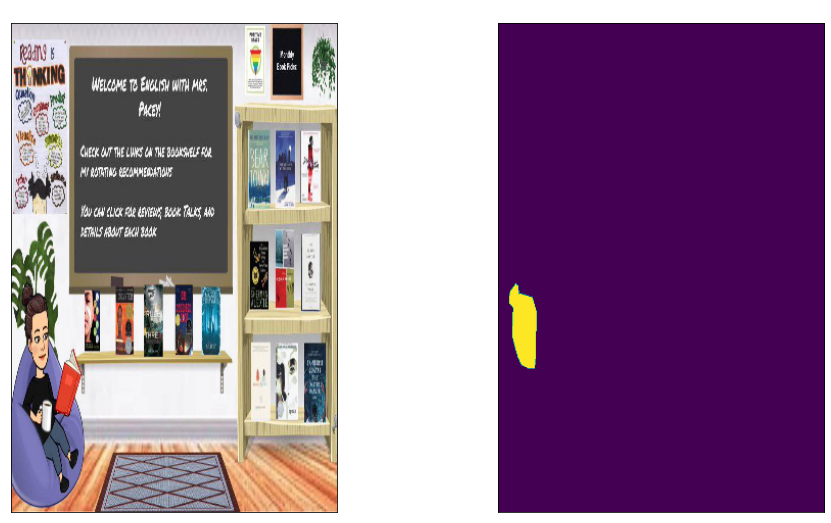

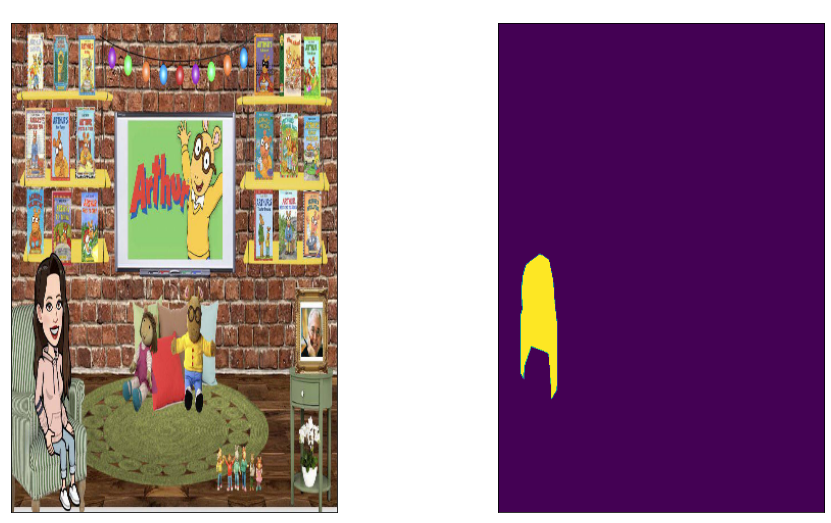

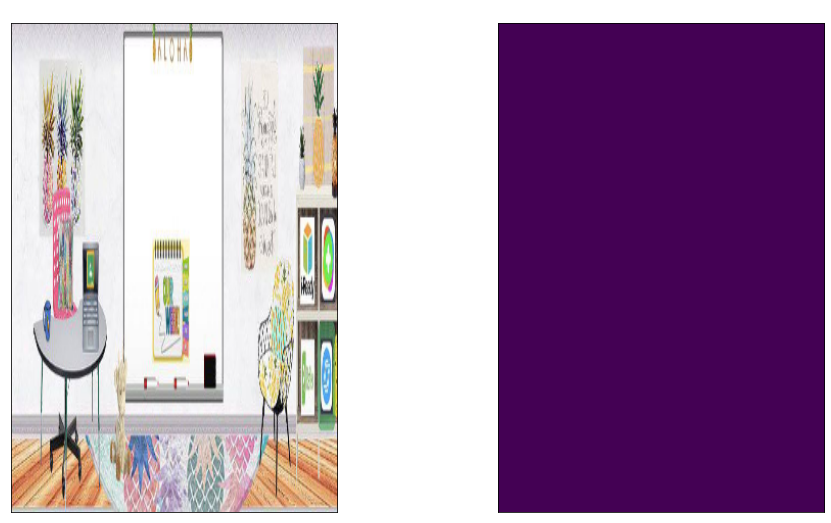

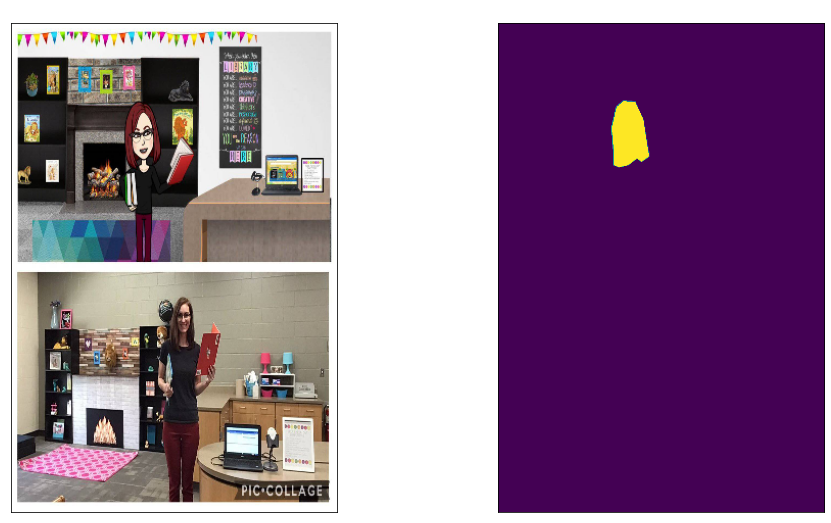

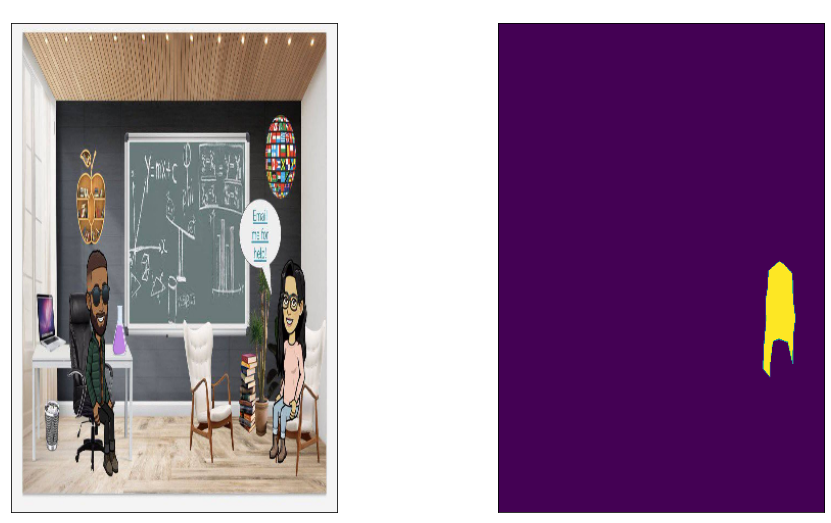

In [2]:
from utils import BitmojiDataset, visualize
y_train_fp = '../data/train-bitmoji_annotation.csv'
x_train_fp = '../data/images'
bitmoji_dataset = BitmojiDataset(y_train_fp,
                                 x_train_fp,
                                 True)

for i in range(5):
    out = bitmoji_dataset[i+123]
    visualize(
        image = out[0],
        mask = out[1].squeeze()
    )

In [15]:
import albumentations as albu

In [16]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.8, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.1),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        )
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/Users/cameron/.local/share/virtualenvs/Bitmoji_Facial_Segmentation-J7HydKGR/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


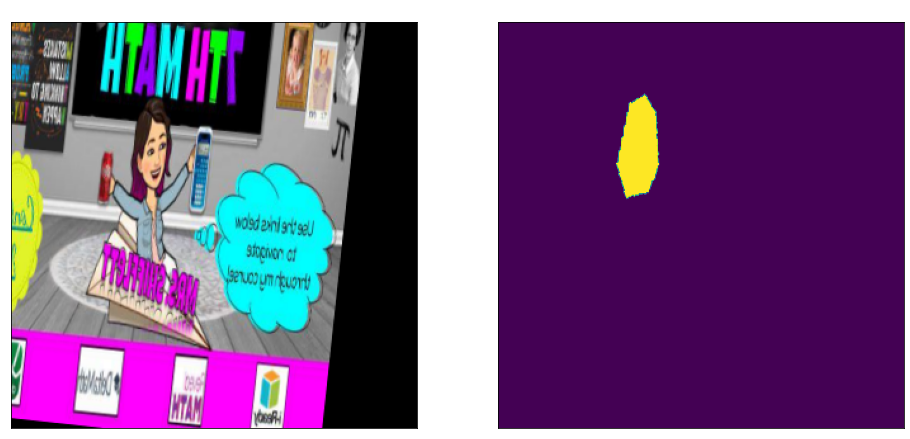

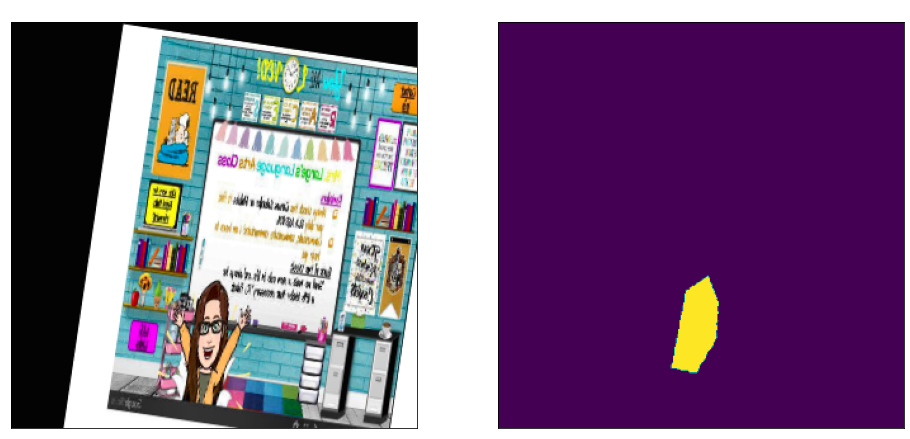

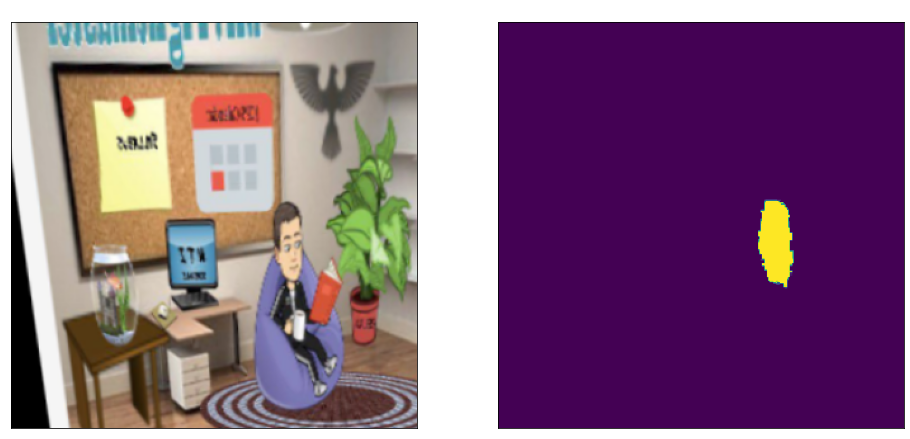

In [17]:
augmented_dataset = BitmojiDataset(y_train_fp,
                                   x_train_fp,
                                   resize=True,
                                   augmentation=get_training_augmentation())

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze())

In [18]:
import gc; gc.collect()

11880

In [19]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['face']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device('cpu')

In [20]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
).to(DEVICE)

In [21]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [22]:
train_dataset = BitmojiDataset(y_train_fp,
                               x_train_fp,
                               True,
                               get_preprocessing(preprocessing_fn), 
                               get_training_augmentation(), 
                               copies=2)
                                     
print('Number of training samples:', len(train_dataset))
y_valid_fp,x_valid_fp = '../data/test-bitmoji_annotation.csv',x_train_fp
valid_dataset = BitmojiDataset(y_valid_fp, 
                               x_valid_fp, 
                               True,
                               get_preprocessing(preprocessing_fn),
                               get_validation_augmentation(), 
                               copies=1)


Number of training samples: 338


In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

In [24]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])


In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)



In [ ]:
max_score = 0

for i in range(0, 40):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '../models/best_model_3.pth')
        print('Model saved!')
        
    if i == 15:
        new_lr = 5e-5
        optimizer.param_groups[0]['lr'] = new_lr
        print(f'Decrease decoder learning rate to {new_lr}!')


Epoch: 0
valid: 100%|████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.25s/it, dice_loss - 0.9041, iou_score - 0.1188]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.27s/it, dice_loss - 0.7525, iou_score - 0.4859]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.53s/it, dice_loss - 0.5842, iou_score - 0.5532]
Model saved!

Epoch: 3
valid: 100%|████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.81s/it, dice_loss - 0.6934, iou_score - 0.3033]

Epoch: 4
train:   0%|                                                                                                   | 0/22 [00:00<?, ?it/s]